# Introduction to variantannotation: package for the aggregation of genomic variant data 

#### Author: C. Mazzaferro & Kathleen Fisch
#### Email: cmazzafe@ucsd.edu
#### Date: January 2017
 
## Outline of Notebook
<a id = "toc"></a>
1. <a href = "#background">Background</a>
2. <a href = "#setup">Set Up File and Libraries</a>
3. <a href = "#ANNOVAR">Run Annovar</a>
4. <a href = "#export1">Export Data To MongoDB: Method 1</a>
5. <a href = "#export2">Export Data To MongoDB: Method 2</a>
6. <a href = "#filter">Variant Filtering</a>
    * <a href = "#tumorvars">Rare Tumor Variant Filter</a>
    * <a href = "#diseasevars">Rare Diesease Variant Filter</a>
    * <a href = "#caddvars">CADD PHRED High Impact Variants</a>
    * <a href = "#own">Create Your Own Filter</a>
7. <a href = "#export">Export CSV and VCF files</a>

<a id = "background"></a>
## Background

This notebook will walk you through the steps of how variants coming from a VCF can be annotated efficiently and thoroughly using the package VAPr. In particular, the package is aimed at providing a way of retrieving variant information using [ANNOVAR](http://annovar.openbioinformatics.org/en/latest/) and [myvariant.info](myvariant.info) and consolidating it in conveninent formats. It is well-suited for bioinformaticians interested in aggregating variant information into a single database for ease of use and to provide higher analysis capabities. 

The aggregation is performed specifically by structuring the data in lists of python dictionaries, with each variant being described by a multi-level dictionary. The choice was made due to the inconsistencies that exist between data availability, and the necessity to store their information in a flexible manner. Further, this specific format permits its parsing to a MongoDb instance (dictionaries are the python representation of JSON objects), which enables the user to efficiently store, query and filter such data. 

Finally, the package also has the added functionality to create csv and vcf files from MongoDB. The class Filters allows the user to rapidly query data that meets certain criteria as a list of documents, and the class FileWriter can transform such list into more widely accepted formats such as vcf and csv files. It should be noted that here, the main differential the package offers is the ability to write these files preserving all the annotation data. In the vcf files, for instance, outputs will have a 'Otherinfo' column where all the data coming from ANNOVAR and myvariant.info is condensed (while still preserving its structure). For vcf files, outputs will have around ~120-200 columns, depending on the amount of variant data that can be retrieved from myvvariant.info. 

Having the data stored in a database offers a variety of benefits. In particular, it enables the user to set customized queries and rapidly iterate over a specific procedure and get maximum reproducibility. It also enables the storage of data coming from different sources, and its rapid access. 

**Notes on required software**

the following libraries will be installed upon installing VAPr:
- myvariant
- pymongo
- pyvcf

Other libraries that are needed, but should natively e installed on most OS: 

- Pandas
- Numpy

Further, a MongoDB database must be set up. Refer to the documentation page for more information. 
Similarly, ANNOVAR must be downloaded, alongside with its supporting databases (also listed on the documentation page).

# Flowchart Diagram

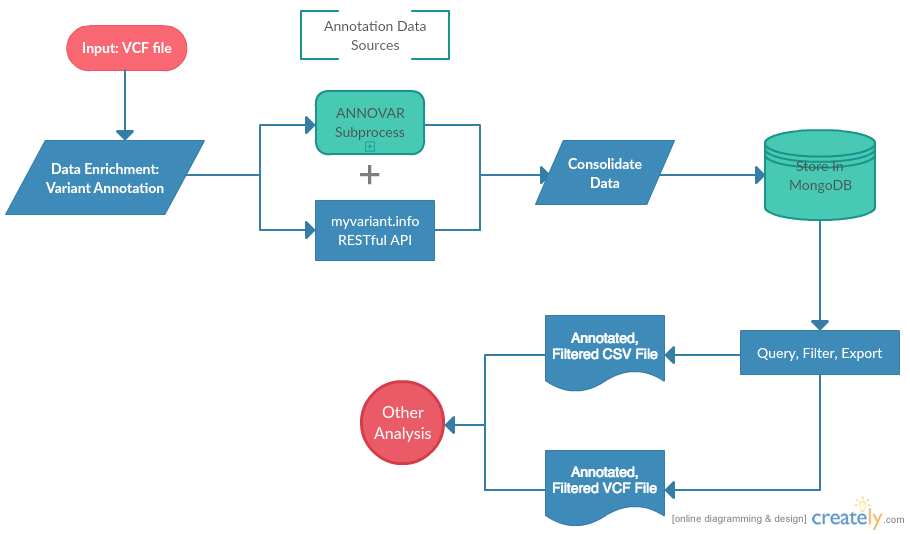

In [2]:
import os
from IPython.display import Image, display, HTML
Image(filename=os.path.dirname(os.path.realpath('__file__')) + 'simpler.jpg') 

<a id = "setup"></a>
## Import libraries

In [79]:
from VAPr import parser_models, annovar_suprocess
import importlib

In [80]:
importlib.reload(parser_models)
importlib.reload(annovar_suprocess)

<module 'VAPr.annovar_suprocess' from '/Users/carlomazzaferro/Documents/CCBB/ucsd-ccbb/VAPr/VAPr/annovar_suprocess.py'>

<a id = "ANNOVAR"></a>
## Run Annovar 

This will run ANNOVAR. A txt file named annotated.hg19_multianno.csv will appear in the OUT_PATH specified. The csv file can then be processed and integrated with the data coming from myvariant.info. 
This command may take a some time to run (5-30 minutes for each file depending on file size).
To keep things simple, we can start by looking at one file only. Let's run annovar on it. In any case, if you have multiple files to work on, you can run them in parallel by running the block after the next one. 

In [81]:
IN_PATH = "/Volumes/Carlo_HD1/CCBB/VAPr_files/vcf_files/not_annotated/Normal_targeted_seq.vcf"
OUT_PATH = "/Volumes/Carlo_HD1/CCBB/VAPr_files/csv_files/"
ANNOVAR_PATH = '/Volumes/Carlo_HD1/CCBB/annovar/'   #location of the scipts and databases

sub_process = annovar_suprocess.AnnovarWrapper(IN_PATH, OUT_PATH, ANNOVAR_PATH)
sub_process.annovar_command_str

'perl /Volumes/Carlo_HD1/CCBB/annovar/table_annovar.pl /Volumes/Carlo_HD1/CCBB/VAPr_files/vcf_files/not_annotated/Normal_targeted_seq.vcf /Volumes/Carlo_HD1/CCBB/annovar/humandb/ -buildver hg19 -out /Volumes/Carlo_HD1/CCBB/VAPr_files/csv_files/annotated -remove -protocol nci60,esp6500siv2_all,clinvar_20161128,popfreq_all_20150413,cosmic70,knownGene,genomicSuperDups,1000g2015aug,tfbsConsSites,targetScanS,cytoBand -operation f,f,f,f,f,g,r,f,r,r,r -nastring . -otherinfo -vcfinput'

In [82]:
sub_process.download_dbs()

Currently downloading database file: annovar_downdb
Currently downloading database file: hg19_nci60
Currently downloading database file: hg19_nci60
Currently downloading database file: hg19_nci60

Annovar finished dowloading on file : hg19_nci60. A .txt file has been created in the ANNOVAR_PATH directory

Currently downloading database file: hg19_nci60
Currently downloading database file: hg19_esp6500siv2_all
Currently downloading database file: hg19_esp6500siv2_all

Annovar finished dowloading on file : hg19_esp6500siv2_all. A .txt file has been created in the ANNOVAR_PATH directory

Currently downloading database file: hg19_clinvar_20161128
Currently downloading database file: hg19_clinvar_20161128
Currently downloading database file: hg19_clinvar_20161128

Annovar finished dowloading on file : hg19_clinvar_20161128. A .txt file has been created in the ANNOVAR_PATH directory

Currently downloading database file: hg19_clinvar_20161128
Currently downloading database file: hg19_esp6500s

'Finished downloading databases to /Volumes/Carlo_HD1/CCBB/annovar/humandb/'

In [5]:
sub_process.run_annovar()

Currently working on VCF file: annotated, field avinput
Currently working on VCF file: annotated, field exonic_variant_function
Currently working on VCF file: annotated, field variant_function
Currently working on VCF file: annotated, field hg19_tfbsConsSites
Currently working on VCF file: annotated, field hg19_cytoBand
Currently working on VCF file: annotated, field hg19_targetScanS
Currently working on VCF file: annotated, field hg19_genomicSuperDups
Currently working on VCF file: annotated, field hg19_esp6500siv2_all_dropped
Currently working on VCF file: annotated, field hg19_esp6500siv2_all_filtered
Currently working on VCF file: annotated, field 2015_08_filtered
Currently working on VCF file: annotated, field 2015_08_dropped
Currently working on VCF file: annotated, field hg19_popfreq_all_20150413_filtered
Currently working on VCF file: annotated, field hg19_popfreq_all_20150413_dropped
Currently working on VCF file: annotated, field hg19_clinvar_20161128_dropped
Currently workin

'Finished running ANNOVAR on /Volumes/Carlo_HD1/CCBB/VAPr_files/vcf_files/not_annotated/Normal_targeted_seq.vcf'

In [156]:
out_annotated = '/Volumes/Carlo_HD1/CCBB/VAPr_files/csv_files/annotated.hg19_multianno.txt'
in_vcf = IN_PATH

#Name collection, dbs
collection_name = "Test_Normal_Targeted"
db_name = 'My_Variant_Database'

<a id = "export1"></a>
## Export Annovar, MyVariant data to MongoDB

With this method, data from annovar (as a txt file) will be obtained 1000 lines at a time.

As soon as you run the scripts from VAPr, variant data will be retrieved from myvariant.info and the data will automatically be integrated and stored to MongoDB. Database and collection name should be specified, and there must be a running MongoDB connection. The script will set up a client to communicate between python (through pymongo) and the the database.

In general, the shell command:

`mongod --dbpath ../data/db`  

Where data/db is the designated location where the data will be stored, will initiate MongoDB. After this, the script should store data to the directory automatically.
For pymongo, and more information on how to set up a Mongo Database: https://docs.mongodb.com/getting-started/python/

In [25]:
vcf_file = '/Volumes/Carlo_HD1/CCBB/VAPr_files/vcf_files/not_annotated/Normal_targeted_seq.vcf'
csv_file = '/Volumes/Carlo_HD1/CCBB/VAPr_files/csv_files/annotated.hg19_multianno.txt'

collection_name = 'My_Variant_Info_Collection_Full'
db_name = 'My_Variant_Database'

pars = parser_models.VariantParsing(vcf_file, collection_name, db_name, annotated_file=csv_file)
pars.push_to_db()

<a id = "export2"></a>
## Export MyVariant data to MongoDB

Easier to run, doesn't require annovar.
Will however be incomplete (some variants will have no information).

In [ ]:
vcf_file = '/Volumes/Carlo_HD1/CCBB/VAPr_files/vcf_files/not_annotated/Normal_targeted_seq.vcf'
csv_file = '/Volumes/Carlo_HD1/CCBB/VAPr_files/csv_files/annotated.hg19_multianno.txt'

collection_name = 'My_Variant_Info_Collection_Full'
db_name = 'My_Variant_Database'

#Ignore annotated_file= input
pars = parser_models.VariantParsing(vcf_file, collection_name, db_name)
pars.push_to_db()

## Create output files by filtering
### See "Notes on Variant Filtering & Output Files" for more info 

In [ ]:
#Apply filter(s).
filter_collection = MongoDB_querying.Filters(db_name, collection_name)  #Filter Object

#Three different filters. Let's use the first one.
rare_cancer_variants = filter_collection.rare_cancer_variant()

#Create 4 output files: annotated vcf, annotated csv, filtered vcf, filtered csv
#All files will contain information from myvariant and ANNOVAR; the filtered ones will be much smaller in size.
out_unfiltered_vcf_file = filepath + "/_unfilterd_vcf_annotated.vcf"
out_unfiltered_csv_file = filepath + "/_unfiltered_csv_annotated.csv"

rare_cancer_variants_csv = filepath + "/_rare_cancer_vars.csv"
rare_cancer_variants_vcf = filepath + "/_rare_cancer_vars.vcf"

#The input gzipped vcf file is required to create a filtered one.
in_vcf_file = filepath + "/normal_targeted_seq.vcf.gz"

#Create writer object that pulls data from MongoDB
my_writer = create_output_files.FileWriter(db_name, collection_name)

#Write collection to csv and vcf
my_writer.generate_unfiltered_annotated_csv(out_unfiltered_csv_file)
my_writer.generate_unfiltered_annotated_vcf(in_vcf_file, out_unfiltered_vcf_file)

#cancer variants filtered files
my_writer.generate_annotated_csv(rare_cancer_variants, rare_cancer_variants_csv)
my_writer.generate_annotated_vcf(rare_cancer_variants, in_vcf_file, rare_cancer_variants_vcf)

### Other methods and capabilities

In [ ]:
#Obtain list of variant ID's from a vcf file
open_file = myvariant_parsing_utils.VariantParsing()
variant_list = open_file.get_variants_from_vcf(vcf_file)

#Or, if file is too large to be held in memory, iterate over it. 
variant_list = open_file.get_variants_from_vcf_chunk(vcf_file, 10000, 0)

#Since data is a 

<a id = "filter"></a>
## Notes on Variant Filtering & Output Files

Here we implement three different filters that allow for the retrieval of specific variants. The filters are implemented as MongoDB queries, and are designed to provie the user with a set of relevant variants. In case the user would like to define its own querying, a template is provided. 
The output of the queries is a list of dictionaries (JSON documents), where each dictionary contains data reltive to one variant. 

Further, the package allows the user to parse these variants into an annotated csv or vcf file. 
If needed, annotated, unfiltered vcf and csv files can also be created. They will have the same length (number of variants) as the original files, but will contain much more complete annotation data coming from myvariant.info and ANNOVAR databases. 

To create a csv file, just the filtered output is needed. To create an annotated vcf file, a tab indexed file (.tbi) file is needed (see comments in  section Create unfiltered annotated vcf and csv files at the end of this page). This can be created using tabix.  

First, the file needs to be compressed:

From the command line, running:

`bgzip -c input_file.vcf > input_file.vcf.gz`

returns `input_vcf_file.vcf.gz`

and running 

`tabix input_vcf_file.vcf.gz`

will return: `input_vcf_file.vcf.gz.tbi`



<a id = "tumorvars"></a>
## Filter #1: specifying cancer-specifc rare variants

 - filter 1: ThousandGenomeAll < 0.05 or info not available
 - filter 2: ESP6500siv2_all < 0.05 or info not available
 - filter 3: cosmic70 information is present
 - filter 4: Func_knownGene is exonic, splicing, or both
 - filter 5: ExonicFunc_knownGene is not "synonymous SNV"
 - filter 6: Read Depth (DP) > 10

In [33]:
aa = ['1','2','3','4','5','6']
for i,_ in enumerate(aa):
    print(type(i))

<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>


In [30]:
tst = '/Users/carlomazzaferro/Documents/CCBB/ucsd-ccbb/VAPr/VAPr/tests/Normal_targeted_seq.vcf'
import vcf
import myvariant
list_ids = []

reader = vcf.Reader(open(tst, 'r'))

for record in reader:
    if len(record.ALT) > 1:
        for alt in record.ALT:
            list_ids.append(myvariant.format_hgvs(record.CHROM, record.POS,
                                                  record.REF, str(alt)))
            print(myvariant.format_hgvs(record.CHROM, record.POS,
                                                  record.REF, str(alt)))
    else:
        list_ids.append(myvariant.format_hgvs(record.CHROM, record.POS,
                                              record.REF, str(record.ALT[0])))


chr1:g.16265061_16265063del
chr1:g.16265060_16265061delinsCT
chr1:g.42774672C>A
chr1:g.42774672_42774673insAAAAAAAAA
chr1:g.148888411_148888425del
chr1:g.148888410_148888415delinsAGTTTT
chr1:g.156842810_156842811insGT
chr1:g.156842810_156842811insGTGT
chr1:g.156845492_156845493insGT
chr1:g.156845492_156845493insGTGT
chr1:g.158580921_158580922insCACA
chr1:g.158580921_158580922insCACACACACA
chr1:g.158656347_158656348insAG
chr1:g.158656347_158656348insAGAG
chr1:g.158656632_158656633insA
chr1:g.158656632_158656633insAA
chr1:g.162750211_162750213del
chr1:g.162750210_162750211delinsCT
chr1:g.235543477_235543492del
chr1:g.235543476_235543478delinsTTG
chr1:g.246007907_246007908insT
chr1:g.246007907_246007908insTT
chr2:g.12003055_12003066del
chr2:g.12003054_12003056delinsATG
chr2:g.47641560_47641563del
chr2:g.47641559_47641562delinsTAAA
chr2:g.113990907_113990908insA
chr2:g.113990907_113990908insAA
chr2:g.142237729_142237744del
chr2:g.142237728_142237730delinsTTG
chr2:g.148602544_148602545insT


In [29]:
list_ids[0]

'chrM:g.146T>C'

In [5]:
filepath = '/data/ccbb_internal/interns/Carlo'

In [9]:
#Create output files (if needed): specify name of files and path 
rare_cancer_variants_csv = filepath + "/tumor_rna_rare_cancer_vars_csv.csv"
rare_cancer_variants_vcf = filepath + "/tumor_rna_rare_cancer_vars_vcf.vcf"
input_vcf_compressed = filepath + '/test_vcf/Tumor_RNAseq_variants.vcf.gz'

#Apply filter.
filter_collection = MongoDB_querying.Filters(db_name, collection_name)
rare_cancer_variants = filter_collection.rare_cancer_variant()

#Crete writer object for filtered lists:
my_writer = create_output_files.FileWriter(db_name, collection_name)

#cancer variants filtered files
my_writer.generate_annotated_csv(rare_cancer_variants, rare_cancer_variants_csv)
my_writer.generate_annotated_vcf(rare_cancer_variants,input_vcf_compressed, rare_cancer_variants_vcf)

Variants found that match rarity criteria: 11


'Finished writing annotated, filtered VCF file'

<a id = "rarevars"></a>
## Filter #2: specifying rare disease-specifc (rare) variants

- filter 1: ThousandGenomeAll < 0.05 or info not available
- filter 2: ESP6500siv2_all < 0.05 or info not available
- filter 3: cosmic70 information is present
- filter 4: Func_knownGene is exonic, splicing, or both
- filter 5: ExonicFunc_knownGene is not "synonymous SNV"
- filter 6: Read Depth (DP) > 10
- filter 7: Clinvar data is present 

In [13]:
#Apply filter.
filter_collection = MongoDB_querying.Filters(db_name, collection_name)
rare_disease_variants = filter_collection.rare_disease_variant()

Variants found that match rarity criteria: 0


Zero variants found. Writing a csv output won't make much sense. You can still customize the filters the way you'd like, as you can see on 'Create your own filter'.

<a id = "caddvars"></a>
## Filter #3: specifying rare disease-specifc (rare) variants with high impact
- filter 1: ThousandGenomeAll < 0.05 or info not available
- filter 2: ESP6500siv2_all < 0.05 or info not available
- filter 3: cosmic70 information is present
- filter 4: Func_knownGene is exonic, splicing, or both
- filter 5: ExonicFunc_knownGene is not "synonymous SNV"
- filter 6: Read Depth (DP) > 10
- filter 7: Clinvar data is present 
- filter 8: cadd.phred > 10

In [ ]:
#Apply filter.
filter_collection = MongoDB_querying.Filters(db_name, collection_name)
rare_high_impact_variants = filter_collection.rare_high_impact_variants()

<a id = "own"></a>
## Create your own filter

As long as you have a MongoDB instance running, filtering can be perfomed trough pymongo as shown by the code below. If a list is intended to be created from it, simply add: `filter2 = list(filter2)`

If you'd like to customize your filters, a good idea would be to look at the available fields to be filtered. Looking at the myvariant.info [documentation](http://docs.myvariant.info/en/latest/doc/data.html), you can see what are all the fields avaialble and can be used for filtering. 

In [ ]:
from pymongo import MongoClient

client = MongoClient()
db = client.My_Variant_Database
collection = db.ANNOVAR_MyVariant_chunks

filter2 = collection.find({ "$and": [
                                 {"$or": [{"ThousandGenomeAll": {"$lt": 0.05}}, {"ThousandGenomeAll": {"$exists": False}}]},
                                 {"$or": [{"ESP6500siv2_all": { "$lt": 0.05}}, {"ESP6500siv2_all": { "$exists": False}}]},
                                 {"$or": [{"Func_knownGene": "exonic"}, {"Func_knownGene": "splicing"}]},
                                 {"ExonicFunc_knownGene": {"$ne": "synonymous SNV"}},
                                 {"Genotype_Call.DP": {"$gte": 10}},
                                 {"cosmic70": { "$exists": True}}
                         ]})


<a id = "export"></a>
## Create unfiltered annotated vcf and csv files 
Let's write an output file that contains all annotation data. This may be useful for researchers interested in obtaining a full description of their files.

In [15]:
#Create output files (if needed): specify name of files and path 
out_unfiltered_vcf_file = filepath + "/out_unfiltered_rnaseq_vcf.vcf"
out_unfiltered_csv_file = filepath + "/out_unfiltered_rnaseq_csv.csv"
input_vcf_compressed = filepath + '/test_vcf/Tumor_RNAseq_variants.vcf.gz'

#Create writer object
#db and collection name must be specified since no list is given. The entire collection will be queried. 
my_writer = create_output_files.FileWriter(db_name, collection_name)

#Write collection to csv and vcf
#The in_vcf_file must be the .vcf.gz file and it needs to have an associated .tbi file. 

my_writer.generate_unfiltered_annotated_csv(out_unfiltered_csv_file)
my_writer.generate_unfiltered_annotated_vcf(input_vcf_compressed, out_unfiltered_vcf_file)

'Finished writing annotated VCF file'